## Compressing models at training time - quantization aware training

Training-time model compression improves model performance by applying optimizations (such as quantization) during the training. The training process minimizes the loss associated with the lower-precision optimizations, so it is able to maintain the model’s accuracy while reducing its latency and memory footprint. 

Generally, training-time model optimization results in better model performance and accuracy than post-training optimization, but it can require more effort to set up.

### Quantization aware training

Quantization is the process of converting the weights and activation values in a neural network from a high-precision format (such as 32-bit floating point) to a lower-precision format (such as 8-bit integer). It helps to reduce the model’s memory footprint and latency. NNCF uses quantization-aware training to quantize models.

Quantization-aware training inserts nodes into the neural network during training that simulate the effect of lower precision. This allows the training algorithm to consider quantization errors as part of the overall training loss that gets minimized during training. The network is then able to achieve enhanced accuracy when quantized.

### Filter pruning

Filter pruning algorithms compress models by zeroing out the output filters of convolutional layers based on a certain filter importance criterion. During fine-tuning, an importance criteria is used to search for redundant filters that don’t significantly contribute to the network’s output and zero them out. After fine-tuning, the zeroed-out filters are removed from the network.

OpenVINO Runtime is a set of C++ libraries with C and Python bindings.

> Note: On Windows, add the directory that contains cl.exe to the PATH to enable PyTorch to find the required C++ tools. This code assumes that Visual Studio 2019 is installed in the default directory. If you have a different C++ compiler, add the correct path to `os.environ["PATH"]` directly. Note that the C++ Redistributable is not enough to run this notebook.

In [49]:
from openvino.tools.mo import convert_model

In [ ]:
from torch import cuda as torchcuda

In [37]:
from pathlib import Path
import os
import sys
import time
import traceback

In [2]:
Path("model")

WindowsPath('model')

In [3]:
import torch
import nncf  # Important - should be imported directly after torch.

from torch import nn
import torch.nn.parallel
from torch import optim
from torch.utils import data
from  torchvision import datasets, models, transforms

from nncf import NNCFConfig
from nncf.torch import create_compressed_model, register_default_init_args

import openvino as ov
from torch.jit import TracerWarning

sys.path.append("../utils")

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.2'


Using cpu device


In [4]:
MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
DATA_DIR = Path(os.path.join(os.environ["DATASETS"], "vegetables", "Vegetable-Images"))
BASE_MODEL_NAME = "resnet18"
image_size = 224

OUTPUT_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
fp32_pth_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".pth")
fp32_onnx_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".onnx")
fp32_ir_path = fp32_onnx_path.with_suffix(".xml")
int8_onnx_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8")).with_suffix(".onnx")
int8_ir_path = int8_onnx_path.with_suffix(".xml")

In [5]:
fp32_pth_path, fp32_ir_path

(WindowsPath('model/resnet18_fp32.pth'),
 WindowsPath('output/resnet18_fp32.xml'))

### Helpers

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=":f"):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = "{name} {val" + self.fmt + "} ({avg" + self.fmt + "})"
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print("\t".join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = "{:" + str(num_digits) + "d}"
        return "[" + fmt + "/" + fmt.format(num_batches) + "]"


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## Initial training

### Train function

In [21]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter("Time", ":3.3f")
    losses = AverageMeter("Loss", ":2.3f")
    top1 = AverageMeter("Acc@1", ":2.2f")
    top5 = AverageMeter("Acc@5", ":2.2f")
    progress = ProgressMeter(
        len(train_loader), [batch_time, losses, top1, top5], prefix="Epoch:[{}]".format(epoch)
    )

    # Switch to train mode.
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        images = images.to(device)
        target = target.to(device)

        # Compute output.
        try:
            output = model(images)
            loss = criterion(output, target)

            # Measure accuracy and record loss.
            losses.update(loss.item(), images.size(0))

            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # Compute gradient and do optimization step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        except Exception as e:
            print(traceback.format_exc())

        # Measure elapsed time.
        batch_time.update(time.time() - end)
        end = time.time()

        print_frequency = 50
        if i % print_frequency == 0:
            progress.display(i)

### Validation function

In [22]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter("Time", ":3.3f")
    losses = AverageMeter("Loss", ":2.3f")
    top1 = AverageMeter("Acc@1", ":2.2f")
    top5 = AverageMeter("Acc@5", ":2.2f")
    progress = ProgressMeter(len(val_loader), [batch_time, losses, top1, top5], prefix="Test: ")

    # Switch to evaluate mode.
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)

            # Compute output.
            try:
                output = model(images)
                loss = criterion(output, target)

            # Measure accuracy and record loss.
                losses.update(loss.item(), images.size(0))
            
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
                top1.update(acc1[0], images.size(0))
                top5.update(acc5[0], images.size(0))
            
            except Exception as e:
                print(traceback.format_exc())

            # Measure elapsed time.
            batch_time.update(time.time() - end)
            end = time.time()

            print_frequency = 10
            if i % print_frequency == 0:
                progress.display(i)

        print(" * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}".format(top1=top1, top5=top5))
    return top1.avg

### Loading data

In [23]:
DATASET_DIR = DATA_DIR

In [24]:
image_size

224

In [31]:
num_classes = 15  # 200 is for Tiny ImageNet, default is 1000 for ImageNet
init_lr = 1e-4
batch_size = 32
epochs = 4

model = models.resnet18(pretrained=True)

# Update the last FC layer for Vegetables number of classes.
num_features = model.fc.in_features
model.fc = nn.Linear(in_features=num_features, out_features=num_classes, bias=True)
model.to(device)

# Data loading code.
train_dir = DATASET_DIR / "train"
val_dir = DATASET_DIR / "validation"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize,
        ]
    ),
)
val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize,
        ]
    ),
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, sampler=None
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Define loss function (criterion) and optimizer.
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

### Training model

In [32]:
load_pretrained = False

In [33]:
if load_pretrained:
    #
    # ** WARNING: The `torch.load` functionality uses Python's pickling module that
    # may be used to perform arbitrary code execution during unpickling. Only load data that you
    # trust.
    #
    path = "./models/vegetables.pt"  # str(fp32_pth_path) or
    checkpoint = torch.load(path, map_location="cpu")
    model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    model.load_state_dict(checkpoint["model_state_dict"], strict=True)
    acc1_fp32 = checkpoint.get("acc1")
else:
    best_acc1 = 0
    # Training loop.
    for epoch in range(0, epochs):
        # Run a single training epoch.
        train(train_loader, model, criterion, optimizer, epoch)

        # Evaluate on validation set.
        acc1 = validate(val_loader, model, criterion)

        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if is_best:
            checkpoint = {"state_dict": model.state_dict(), "acc1": acc1}
            torch.save(checkpoint, fp32_pth_path)
    acc1_fp32 = best_acc1
    
print(f"Accuracy of FP32 model: {acc1_fp32:.3f}")

Epoch:[0][  0/469]	Time 4.806 (4.806)	Loss 2.945 (2.945)	Acc@1 3.12 (3.12)	Acc@5 40.62 (40.62)
Epoch:[0][ 50/469]	Time 5.543 (4.948)	Loss 0.169 (0.753)	Acc@1 100.00 (83.39)	Acc@5 100.00 (94.12)
Epoch:[0][100/469]	Time 5.797 (5.059)	Loss 0.024 (0.420)	Acc@1 100.00 (91.34)	Acc@5 100.00 (97.03)
Epoch:[0][150/469]	Time 6.121 (5.152)	Loss 0.020 (0.298)	Acc@1 100.00 (93.92)	Acc@5 100.00 (98.01)
Epoch:[0][200/469]	Time 4.406 (5.038)	Loss 0.021 (0.232)	Acc@1 100.00 (95.35)	Acc@5 100.00 (98.51)
Epoch:[0][250/469]	Time 4.422 (4.956)	Loss 0.006 (0.190)	Acc@1 100.00 (96.20)	Acc@5 100.00 (98.80)
Epoch:[0][300/469]	Time 5.834 (4.959)	Loss 0.014 (0.164)	Acc@1 100.00 (96.74)	Acc@5 100.00 (99.00)
Epoch:[0][350/469]	Time 5.556 (5.029)	Loss 0.009 (0.142)	Acc@1 100.00 (97.19)	Acc@5 100.00 (99.15)
Epoch:[0][400/469]	Time 5.252 (5.056)	Loss 0.092 (0.127)	Acc@1 96.88 (97.48)	Acc@5 100.00 (99.24)
Epoch:[0][450/469]	Time 4.923 (5.061)	Loss 0.008 (0.115)	Acc@1 100.00 (97.70)	Acc@5 100.00 (99.33)
Test: [ 0/94]	T

KeyboardInterrupt: 

In [34]:
print(f"Accuracy of FP32 model: {best_acc1:.3f}")

Accuracy of FP32 model: 99.900


## Converting the models

### 1. Export model to onnx

In [35]:
dummy_input = torch.randn(1, 3, image_size, image_size).to(device)

torch.onnx.export(model, dummy_input, fp32_onnx_path)
print(f"FP32 ONNX model was exported to {fp32_onnx_path}.")

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

FP32 ONNX model was exported to output\resnet18_fp32.onnx.


### 2. Compress model to `int8`

In [36]:
OUTPUT_DIR

WindowsPath('output')

#### Initialize quantization

In [37]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3, image_size, image_size]},
    "log_dir": str(OUTPUT_DIR),  # The log directory for NNCF-specific logging outputs.
    "compression": {
        "algorithm": "quantization",  # Specify the algorithm here.
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

Provide a data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics, using a given number of samples.

In [38]:
nncf_config = register_default_init_args(nncf_config, train_loader)

Create a wrapped model ready for compression fine-tuning from a pre-trained `FP32` model and a configuration object.

#### Compress model

In [39]:
compression_ctrl, compressed_model = create_compressed_model(model, nncf_config)

INFO:nncf:Collecting tensor statistics |██              | 1 / 8
INFO:nncf:Collecting tensor statistics |████            | 2 / 8
INFO:nncf:Collecting tensor statistics |██████          | 3 / 8
INFO:nncf:Collecting tensor statistics |████████        | 4 / 8
INFO:nncf:Collecting tensor statistics |██████████      | 5 / 8
INFO:nncf:Collecting tensor statistics |████████████    | 6 / 8
INFO:nncf:Collecting tensor statistics |██████████████  | 7 / 8
INFO:nncf:Collecting tensor statistics |████████████████| 8 / 8
INFO:nncf:Compiling and loading torch extension: quantized_functions_cpu...
Reason: Error building extension 'quantized_functions_cpu': [1/3] cl /showIncludes -DTORCH_EXTENSION_NAME=quantized_functions_cpu -DTORCH_API_INCLUDE_EXTENSION_H -IC:\Python11\Lib\site-packages\nncf\torch\extensions\include -IC:\Python11\Lib\site-packages\torch\include -IC:\Python11\Lib\site-packages\torch\include\torch\csrc\api\include -IC:\Python11\Lib\site-packages\torch\include\TH -IC:\Python11\Lib\site-p

INFO:nncf:Finished loading torch extension: quantized_functions_cpu
INFO:nncf:BatchNorm statistics adaptation |█               | 7 / 63
INFO:nncf:BatchNorm statistics adaptation |███             | 14 / 63
INFO:nncf:BatchNorm statistics adaptation |█████           | 21 / 63
INFO:nncf:BatchNorm statistics adaptation |███████         | 28 / 63
INFO:nncf:BatchNorm statistics adaptation |████████        | 35 / 63
INFO:nncf:BatchNorm statistics adaptation |██████████      | 42 / 63
INFO:nncf:BatchNorm statistics adaptation |████████████    | 49 / 63
INFO:nncf:BatchNorm statistics adaptation |██████████████  | 56 / 63
INFO:nncf:BatchNorm statistics adaptation |████████████████| 63 / 63


In [40]:
acc1 = validate(val_loader, compressed_model, criterion)
print(f"Accuracy of initialized INT8 model: {acc1:.3f}")

Test: [ 0/94]	Time 2.796 (2.796)	Loss 0.004 (0.004)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [10/94]	Time 4.009 (3.389)	Loss 0.001 (0.005)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [20/94]	Time 3.542 (3.487)	Loss 0.001 (0.003)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [30/94]	Time 3.279 (3.491)	Loss 0.001 (0.003)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [40/94]	Time 3.362 (3.518)	Loss 0.002 (0.002)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [50/94]	Time 3.492 (3.505)	Loss 0.003 (0.002)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [60/94]	Time 3.266 (3.497)	Loss 0.003 (0.002)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [70/94]	Time 3.725 (3.520)	Loss 0.010 (0.002)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [80/94]	Time 3.582 (3.545)	Loss 0.001 (0.003)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Test: [90/94]	Time 3.623 (3.555)	Loss 0.017 (0.003)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
 * Acc@1 100.000 Acc@5 100.000
Accuracy 

### 3. Fine-tune the compressed model

In [42]:
compression_lr = init_lr / 10
optimizer = torch.optim.Adam(compressed_model.parameters(), lr=compression_lr)

# Train for one epoch with NNCF.
train(train_loader, compressed_model, criterion, optimizer, epoch=0)

# Evaluate on validation set after Quantization-Aware Training (QAT case).
acc1_int8 = validate(val_loader, compressed_model, criterion)

print(f"Accuracy of tuned INT8 model: {acc1_int8:.3f}")
print(f"Accuracy drop of tuned INT8 model over pre-trained FP32 model: {acc1_fp32 - acc1_int8:.3f}")

Epoch:[0][  0/469]	Time 9.593 (9.593)	Loss 0.007 (0.007)	Acc@1 100.00 (100.00)	Acc@5 100.00 (100.00)
Epoch:[0][ 50/469]	Time 9.370 (9.813)	Loss 0.003 (0.007)	Acc@1 100.00 (99.88)	Acc@5 100.00 (100.00)
Epoch:[0][100/469]	Time 9.969 (9.579)	Loss 0.001 (0.006)	Acc@1 100.00 (99.91)	Acc@5 100.00 (100.00)
Epoch:[0][150/469]	Time 9.318 (9.444)	Loss 0.003 (0.006)	Acc@1 100.00 (99.92)	Acc@5 100.00 (100.00)
Epoch:[0][200/469]	Time 9.255 (9.398)	Loss 0.002 (0.005)	Acc@1 100.00 (99.94)	Acc@5 100.00 (100.00)
Epoch:[0][250/469]	Time 9.313 (9.434)	Loss 0.009 (0.005)	Acc@1 100.00 (99.95)	Acc@5 100.00 (100.00)
Epoch:[0][300/469]	Time 9.141 (9.462)	Loss 0.003 (0.004)	Acc@1 100.00 (99.96)	Acc@5 100.00 (100.00)
Epoch:[0][350/469]	Time 10.025 (9.497)	Loss 0.001 (0.004)	Acc@1 100.00 (99.96)	Acc@5 100.00 (100.00)
Epoch:[0][400/469]	Time 9.314 (9.553)	Loss 0.001 (0.004)	Acc@1 100.00 (99.95)	Acc@5 100.00 (100.00)
Epoch:[0][450/469]	Time 10.112 (9.535)	Loss 0.001 (0.004)	Acc@1 100.00 (99.95)	Acc@5 100.00 (100.0

NameError: name 'acc1_fp32' is not defined

### 4. Export compressed Int8 model to onnx

In [58]:
compression_ctrl.export_model(int8_onnx_path)
print(f"INT8 ONNX model exported to {int8_onnx_path}.")

C:\Python11\Lib\site-packages\nncf\torch\quantization\layers.py:338: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_low.item()
C:\Python11\Lib\site-packages\nncf\torch\quantization\layers.py:346: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return self._level_high.item()


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

INT8 ONNX model exported to output\resnet18_int8.onnx.


### 5. Export compressed fp32 and int8 models to onnx

In [55]:
from openvino.runtime import serialize

In [56]:
if not fp32_ir_path.exists():
    model = convert_model(
        input_model=fp32_onnx_path,
        input=[1, 3, image_size, image_size],
    )
    serialize(model, fp32_ir_path)

In [59]:
if not int8_ir_path.exists():
    model = convert_model(
        input_model=int8_onnx_path,
        input=[1, 3, image_size, image_size],
    )
    serialize(model, int8_ir_path)

## Benchmarking comparison

In [60]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if 'FPS' in line]
    print(*parsed_output, sep='\n')


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('Benchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
[ INFO ] Throughput:   67.89 FPS
Benchmark INT8 model (IR)
[ INFO ] Throughput:   108.68 FPS


## inference

In [2]:
import openvino.runtime as ov

In [3]:
core = ov.Core()

In [4]:
model_xml = "output/resnet18_int8.xml"
model = core.read_model(model=model_xml)
compiled_model = core.compile_model(model=model, device_name="CPU")

In [5]:
output_layer = compiled_model.output(0)

In [6]:
output_layer

<ConstOutput: names[output.0] shape[1,15] type: f32>

In [120]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(1, 3, 224, 224)


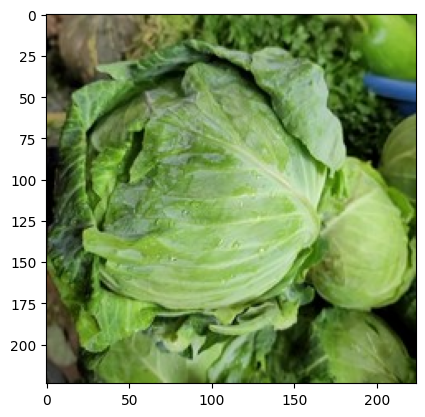

In [130]:
img = Image.open("./test/cabbage.jpg")
print(type(img))

image = np.array(img)
input_image = np.expand_dims(image.reshape((3, 224, 224)), 0)
print(input_image.shape)
plt.imshow(image)
plt.show()

In [131]:
MEAN = 255 * np.array([0.485, 0.456, 0.406])
STD = 255 * np.array([0.229, 0.224, 0.225])

x = np.array(img)
x = x.transpose(-1, 0, 1)
x = (x - MEAN[:, None, None]) / STD[:, None, None]
x = np.expand_dims(x, 0)
np.round(x, 2)

array([[[[ 0.3 ,  0.26,  0.07, ..., -0.42, -0.47, -0.53],
         [ 0.38,  0.35,  0.19, ..., -0.49, -0.47, -0.47],
         [ 0.35,  0.37,  0.3 , ..., -0.47, -0.44, -0.42],
         ...,
         [-1.43, -1.16, -0.99, ..., -1.02, -1.3 , -1.69],
         [-1.6 , -1.35, -1.04, ..., -1.24, -1.42, -1.55],
         [-1.52, -1.35, -1.07, ..., -1.38, -1.43, -1.38]],

        [[-0.02, -0.06, -0.29, ...,  0.7 ,  0.7 ,  0.64],
         [ 0.07,  0.03, -0.16, ...,  0.63,  0.64,  0.7 ],
         [ 0.03,  0.05, -0.02, ...,  0.59,  0.63,  0.68],
         ...,
         [-1.32, -1.04, -0.88, ..., -0.5 , -0.83, -1.23],
         [-1.53, -1.27, -0.92, ..., -0.72, -0.92, -1.06],
         [-1.44, -1.27, -0.95, ..., -0.86, -0.93, -0.88]],

        [[-0.27, -0.31, -0.48, ..., -1.37, -1.42, -1.47],
         [-0.15, -0.18, -0.36, ..., -1.4 , -1.42, -1.39],
         [-0.15, -0.13, -0.2 , ..., -1.35, -1.32, -1.28],
         ...,
         [-1.18, -0.9 , -0.69, ..., -1.32, -1.58, -1.8 ],
         [-1.39, -1.12, -0

In [123]:
import torch
from  torchvision import datasets, transforms

In [132]:
to_tensor = transforms.ToTensor()
torchimg = to_tensor(img).unsqueeze(0)

In [133]:
torchimg

tensor([[[[0.5529, 0.5451, 0.5020,  ..., 0.3882, 0.3765, 0.3647],
          [0.5725, 0.5647, 0.5294,  ..., 0.3725, 0.3765, 0.3765],
          [0.5647, 0.5686, 0.5529,  ..., 0.3765, 0.3843, 0.3882],
          ...,
          [0.1569, 0.2196, 0.2588,  ..., 0.2510, 0.1882, 0.0980],
          [0.1176, 0.1765, 0.2471,  ..., 0.2000, 0.1608, 0.1294],
          [0.1373, 0.1765, 0.2392,  ..., 0.1686, 0.1569, 0.1686]],

         [[0.4510, 0.4431, 0.3922,  ..., 0.6118, 0.6118, 0.6000],
          [0.4706, 0.4627, 0.4196,  ..., 0.5961, 0.6000, 0.6118],
          [0.4627, 0.4667, 0.4510,  ..., 0.5882, 0.5961, 0.6078],
          ...,
          [0.1608, 0.2235, 0.2588,  ..., 0.3451, 0.2706, 0.1804],
          [0.1137, 0.1725, 0.2510,  ..., 0.2941, 0.2510, 0.2196],
          [0.1333, 0.1725, 0.2431,  ..., 0.2627, 0.2471, 0.2588]],

         [[0.3451, 0.3373, 0.2980,  ..., 0.0980, 0.0863, 0.0745],
          [0.3725, 0.3647, 0.3255,  ..., 0.0902, 0.0863, 0.0941],
          [0.3725, 0.3765, 0.3608,  ..., 0

In [134]:
result_infer = compiled_model(input_image)[output_layer]
result_index = np.argmax(result_infer)
print(result_index)

4


In [135]:
result_infer = compiled_model(norm_img)[output_layer]
result_index = np.argmax(result_infer)
print(result_index)

14


In [136]:
result_infer = compiled_model(torchimg)[output_layer]
result_index = np.argmax(result_infer)
print(result_index)

5


In [137]:
result_infer = compiled_model(x)[output_layer]
result_index = np.argmax(result_infer)
print(result_index)

5
